In [1]:
# analisar tudo, só com o 2tri e com o 3tri

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

dash_fundamentus = pd.read_excel('estquant_fundamentus_gabriel.xlsx')

# escolha de trimestres
dash_fundamentus = dash_fundamentus.iloc[137:, :]
dash_fundamentus.columns

# removendo outliers
for i in range(1, len(dash_fundamentus.columns)-3):
    dash_fundamentus.iloc[:, i] = dash_fundamentus.iloc[:, i].clip(lower=-2.5, upper=4)    

# features
features = np.array(dash_fundamentus[['Ebit 2-1t Ltm', 'Ebitda 2-1t Ltm', 'Cfo 2-1t Ltm']])    

In [2]:
# definicao do target e matriz analise
def determine_quartile(value, quartil1, quartil2, quartil3):
    if value <= quartil1:
        return 1
    elif value <= quartil2:
        return 2
    elif value <= quartil3:
        return 3
    else:
        return 4

def input_label_classes(df):
    nome_acoes = np.array(df['Cod'])
    retorno_acoes = np.array(df['Perf_pos2t'])
    rank = (retorno_acoes - np.min(retorno_acoes)) / (np.max(retorno_acoes) - np.min(retorno_acoes))

    Q1 = np.percentile(rank, 25)
    Q2 = np.percentile(rank, 50) 
    Q3 = np.percentile(rank, 75)

    quartile_labels = np.array([determine_quartile(x, Q1, Q2, Q3) for x in rank])
    target= np.column_stack((nome_acoes, retorno_acoes, quartile_labels))
    return target

target = input_label_classes(dash_fundamentus)
X = np.column_stack([features, target[:,-2:]])
X = X.astype(float)

In [3]:
# definicao dos grupos dos features e targets
def determine_quartile(value, quartil1, quartil2, quartil3):
    if value <= quartil1:
        return 1
    elif value <= quartil2:
        return 2
    elif value <= quartil3:
        return 3
    else:
        return 4

def input_label_classes(df, coluna):
    nome_acoes = np.array(df['Cod'])
    retorno_acoes1 = np.array(df['Perf_pos2t']) 
    retorno_acoes = np.array(df[coluna])
    rank = (retorno_acoes - np.min(retorno_acoes)) / (np.max(retorno_acoes) - np.min(retorno_acoes))

    Q1 = np.percentile(rank, 25)
    Q2 = np.percentile(rank, 50) 
    Q3 = np.percentile(rank, 75)

    quartile_labels = np.array([determine_quartile(x, Q1, Q2, Q3) for x in rank])
    target= np.column_stack((nome_acoes, retorno_acoes1, quartile_labels))
    return target

separacao_quartis = input_label_classes(dash_fundamentus.iloc[:,:], 'Ebit 1t')
separacao_quartis[:, -1]

X = np.array(separacao_quartis[:, -1])
lista = [ 'Ebit 2-1t Ltm', 'Ebitda 2-1t Ltm', 'Cfo 2-1t Ltm']

for i in range(1, features.shape[1]):
    separacao_quartis = input_label_classes(dash_fundamentus.iloc[:,:], lista[i])
    X = np.column_stack([X, separacao_quartis[:, -1]])
X = np.column_stack([X, target[:,-2:]])
X = X.astype(float)    

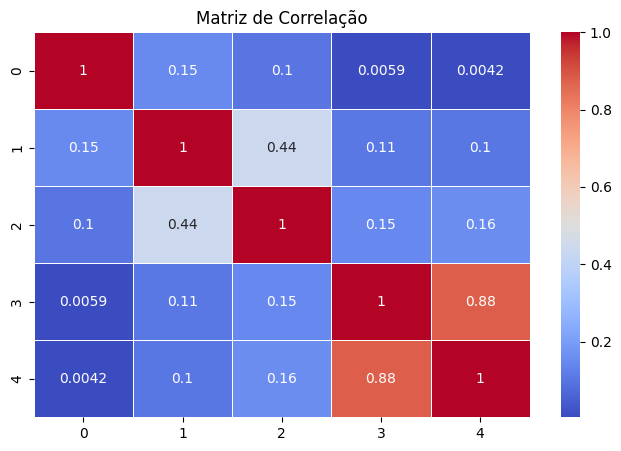

In [4]:
# matriz correl
df = pd.DataFrame(X)
correlation_matrix = df.corr()

# Plotando a matriz de correlação
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title("Matriz de Correlação")
plt.show()

In [5]:
print(f'Media de retornos toda amostra: {round(np.mean(X[:, 3]), 4)}')
print(f'Mediana de retornos toda amostra: {round(np.median(X[:, 3]), 4)}')
print('')


Media de retornos toda amostra: 0.0952
Mediana de retornos toda amostra: 0.0768



In [6]:
for i in range(3):
    print(f'Indicador: {lista[i]}')
    print(f'Media de retornos melhor quartil: {round(np.mean(X[X[:,i]==4][:, 3]), 4)}')
    print(f'Mediana de retornos melhor quartil: {round(np.median(X[X[:,i]==4][:, 3]), 4)}')
    print('')

for i in range(3):
    print(f'Indicador: {lista[i]}')
    print(f'Media de retornos pior quartil: {round(np.mean(X[X[:,i]==1][:, 3]), 4)}')
    print(f'Mediana de retornos pior quartil: {round(np.median(X[X[:,i]==1][:, 3]), 4)}')
    print('')    

Indicador: Ebit 2-1t Ltm
Media de retornos melhor quartil: 0.0904
Mediana de retornos melhor quartil: 0.0686

Indicador: Ebitda 2-1t Ltm
Media de retornos melhor quartil: 0.144
Mediana de retornos melhor quartil: 0.114

Indicador: Cfo 2-1t Ltm
Media de retornos melhor quartil: 0.148
Mediana de retornos melhor quartil: 0.1278

Indicador: Ebit 2-1t Ltm
Media de retornos pior quartil: 0.0993
Mediana de retornos pior quartil: 0.0525

Indicador: Ebitda 2-1t Ltm
Media de retornos pior quartil: 0.097
Mediana de retornos pior quartil: 0.0673

Indicador: Cfo 2-1t Ltm
Media de retornos pior quartil: 0.0744
Mediana de retornos pior quartil: 0.0594



In [8]:
ativos1 = target[X[:, 0]==4, 0]
ativos2 = target[X[:, 1]==4, 0]
ativos3 = target[X[:, 2]==4, 0]

max_length = max(len(ativos1),len(ativos2), len(ativos3) )


def pad_with_none(array, max_length):
    # Convertendo o array para uma lista de strings
    array_str = array.astype(str)
    
    # Preenchendo a lista com valores None
    while len(array_str) < max_length:
        array_str = np.append(array_str, None)
    
    return array_str

# Ajustar os tamanhos dos arrays
array1_padded = pad_with_none(ativos1, max_length)
array2_padded = pad_with_none(ativos2, max_length)
array3_padded = pad_with_none(ativos3, max_length)

# Criando o DataFrame
melhores_acoes = pd.DataFrame({lista[0]: array1_padded, lista[1]: array2_padded, lista[2]: array3_padded})
melhores_acoes.to_excel('/Users/gabrielassuncao/Desktop/rank.xlsx')